# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | S'ave and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [34]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [35]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-26 16:49:45--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.


HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-26 16:49:45--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf85af04018d338be0c68a56a39.dl.dropboxusercontent.com/cd/0/inline/COCr5BGNvKeq-6JD4IpZZrqI7pDeb0Qmu-RKlNJKUeRnQFEaej4jyMAr1tmARrM8rpSfozbfrr9gVpznWWpM-Ed9leUeRVKZOAeKmR_V20oK-MUSvGFIcCayKpTw2mgJjiw/file# [following]
--2024-02-26 16:49:46--  https://ucf85af04018d338be0c68a56a39.dl.dropboxusercontent.com/cd/0/inline/COCr5BGNvKeq-6JD4IpZZrqI7pDeb0Qmu-RKlNJKUeRnQFEaej4jyMAr1tmARrM8rpSfozbfrr9gVpznWWpM-Ed9leUeRVKZOAeKmR_V20oK-MUSvGFIcCayKpTw2mgJjiw/file
Resolving ucf85af04018d338be0c68a56a39.dl.dropboxusercontent.com (ucf85af04018d338be0c68a56a39.dl.dropboxusercontent.com)... 162.125.64.15, 2620:100:6020:15::a27d:400f
Connecting to ucf85af04018d338be0c

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

/tmp/ipykernel_16161/276553290.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(training_img_path)


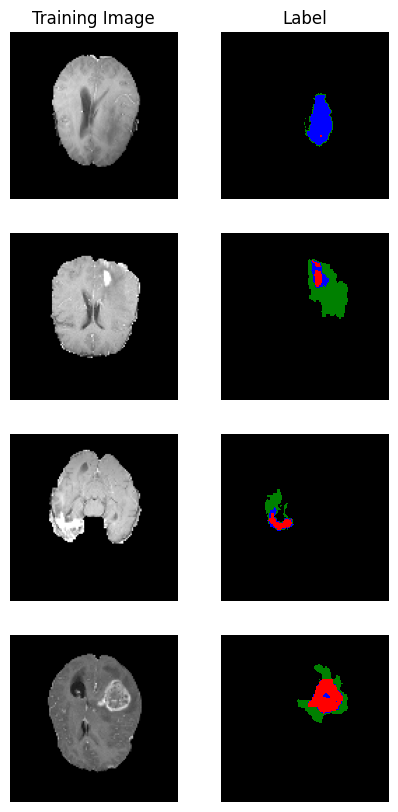

In [36]:
### Insert your code ###
cmap_image = "gray"
cmap_segmentation = colors.ListedColormap(['black', 'green', 'blue', 'red'])

zs = [46, 62, 77, 93, 108, 124]
IMAGES_FROM = 1
IMAGES_TO = 483
from random import randint
from random import choice
from mpl_toolkits.axes_grid1 import ImageGrid
import os

# figure = plt.figure(figsize = (4, 2))
# img_grid = ImageGrid(figure, 111, nrows_ncols = (4, 2), axes_pad =3)
figure, img_grid = plt.subplots(nrows=4, ncols=2, figsize = (5, 10))

titles = ["Training Image", "Label"]
[ax.set_title(col_title) for ax, col_title in zip(img_grid[0], titles)]


for root, dirs, files in os.walk("./Task01_BrainTumour_2D/training_images/", topdown = False):
  chosen = []
  for _ in range(4):
    chosen.append(choice(files))

path = "Task01_BrainTumour_2D"
training_path = "training_images"
label_path = "training_labels"

for i, img_path in enumerate(chosen):
  training_img_path = f"{path}/{training_path}/{img_path}"
  label_img_path = f"{path}/{label_path}/{img_path}"
  
  ## Training Image
  img = imageio.imread(training_img_path)
  img_grid[i, 0].imshow(img, cmap = cmap_image)
  img_grid[i, 0].axis("off")
  
  ## Label Map
  label_img= imageio.v3.imread(label_img_path)
  
  img_grid[i, 1].imshow(label_img, cmap = cmap_segmentation)
  img_grid[i, 1].axis("off")
### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [37]:

def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.v3.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.v3.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []
        
        ### Insert your code ###
        
        # seed = np.random.default_rng().integers(low=0, high=2048) # arbitratry range can be changed
        indices = np.random.randint(0, len(self), batch_size)
        
        for i in indices:
          i, l = self[i]
          images.append(i)
          labels.append(l)
        
        
        images = np.array(images)
        labels = np.array(labels)
        
        ## add the greyscale colour channel so conv2d works correctly
        images = np.reshape(images, (batch_size, 1, images.shape[1], images.shape[2])) 
        
        return images, labels
            
        ### End of your code ###

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [38]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ###
        n //= 2 # 64
        self.upconv5 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2) # 128 -> 64 ch (x2 dims)
        self.conv5 = nn.Sequential(
          nn.Conv2d(n * 2, n, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU()
        )
        n //= 2 # 32
        self.upconv6 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2 ) # 64 -> 32 ch (x2 dims)
        self.conv6 = nn.Sequential(
          nn.Conv2d(n * 2, n, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU()
        )
        
        n //= 2 # 16
        self.upconv7 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2) # 32 -> 16 ch (x2 dims)
        self.conv7 = nn.Sequential(
          nn.Conv2d(n * 2 , n, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, n, kernel_size=3, padding=1),
          nn.BatchNorm2d(n),
          nn.ReLU(),
          nn.Conv2d(n, output_channel, kernel_size=1) ## final 1x1 conv
        )
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x
        
        x = self.conv2(x)
        conv2_skip = x
        
        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)
        
        # Decoder
        ### Insert your code ###
        x = self.conv5(torch.cat([self.upconv5(x), conv3_skip], dim=1))
        
        x = self.conv6(torch.cat([self.upconv6(x), conv2_skip], dim=1))
        
        x = self.conv7(torch.cat([self.upconv7(x), conv1_skip], dim=1))
        
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [39]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    
    
    logits = model(images)


    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()  # Clear the gradients
    loss = criterion(logits, labels)  # Calculate the loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update the model parameters

    print(f'Iteration: {it}/{num_iter}, Loss: {loss.item()}')
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            total_loss = 0
            input_images, real_labels = test_set.get_random_batch(eval_batch_size)
            input_images, real_labels = torch.from_numpy(input_images), torch.from_numpy(real_labels)
            input_images, real_labels = input_images.to(device, dtype=torch.float32), real_labels.to(device, dtype=torch.long)
            outputs = model(input_images)
            
            loss = criterion(outputs, real_labels)
            total_loss += loss.item()
            avg_loss = total_loss / eval_batch_size
            
            print(f"Average test loss: {avg_loss: .4f}")
            
            
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iteration: 1/10000, Loss: 1.2743040323257446
Iteration: 2/10000, Loss: 1.210796594619751
Iteration: 3/10000, Loss: 1.1650866270065308
Iteration: 4/10000, Loss: 1.132899522781372
Iteration: 5/10000, Loss: 1.1023021936416626
Iteration: 6/10000, Loss: 1.0788320302963257
Iteration: 7/10000, Loss: 1.0628032684326172
Iteration: 8/10000, Loss: 1.039315104484558
Iteration: 9/10000, Loss: 1.0210868120193481
Iteration: 10/10000, Loss: 1.000687837600708
Iteration: 11/10000, Loss: 0.9852638840675354
Iteration: 12/10000, Loss: 0.9874458312988281
Iteration: 13/10000, Loss: 0.9534912109375
Iteration: 14/10000, Loss: 0.9517220258712769
Iteration: 15/10000, Loss: 0.9274937510490417
Iteration: 16/10000, Loss: 0.9112583994865417
Iteration: 17/10000, Loss: 0.9110313057899475
Iteration: 18/10000, Loss: 0.9127932190895081
Iteration: 19/10000, Loss: 0.8892919421195984
Iteration: 20/10000, Loss: 0.8679654002189636
Iteration: 21/10000, Loss: 0.8734094500541687
Iteration: 22/10000, Loss: 0.85841143

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

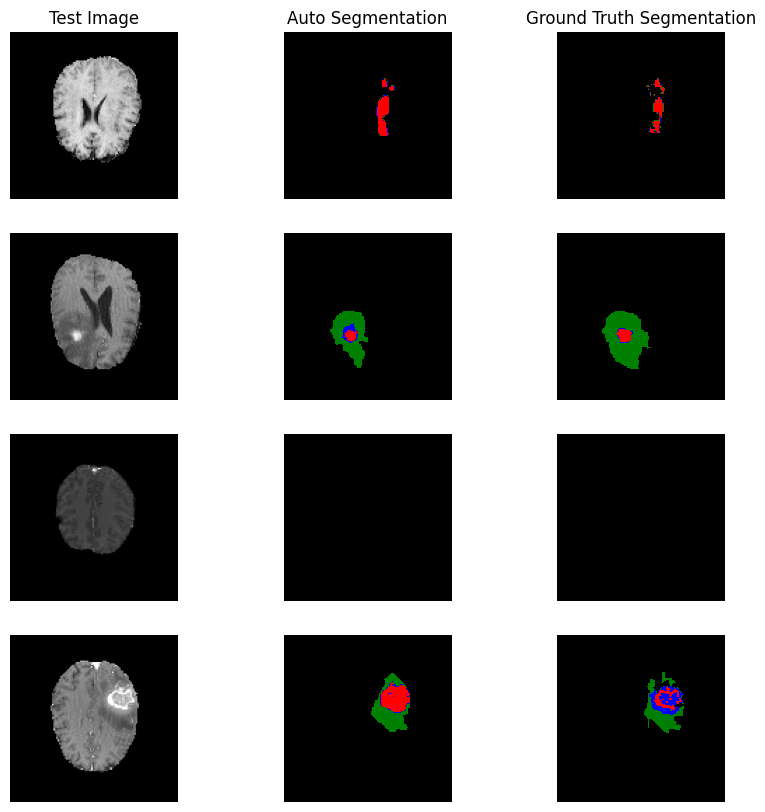

In [43]:
### Insert your code ###
import matplotlib.pyplot as plt


deploy_size = 4
img_dim = (120, 120)

model.eval()
## Get a random set of 4 test images
test_images, test_labels = test_set.get_random_batch(deploy_size)
d_test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)

## Perform inference on the test images
outputs = model(d_test_images)
predicted_labels = torch.argmax(outputs, dim=1).cpu().detach().numpy()

## Visualize the test images, automated segmentation, and ground truth segmentation
fig, grid = plt.subplots(deploy_size, 3, figsize=(10, 10))

## Add titles
titles = ["Test Image", "Auto Segmentation", "Ground Truth Segmentation"]
[ax.set_title(col_title) for ax, col_title in zip(grid[0], titles)]

for i in range(deploy_size):
    grid[i, 0].imshow(test_images[i, 0], cmap=cmap_image)
    grid[i, 0].axis('off')

    grid[i, 1].imshow(predicted_labels[i], cmap = cmap_segmentation)
    grid[i, 1].axis('off')

    grid[i, 2].imshow(test_labels[i], cmap = cmap_segmentation)
    grid[i, 2].axis('off')

plt.show()

  

### End of your code ###


## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

#### **Does your trained model work well?**
To be able to comment on these there are few factors we need to consider. Big part that plays into this is the models performance, in terms of the average loss the model performs pretty well (0.0031) However, to comment on the full performance we should also bring in other metrics such as precision, recall and even evaluate the F1 score to get a better idea of the model.

#### **How would you improve this model...**
In terms of improvements, we can use a more complex or deeper convolutional neural network that can extract and 'learn' more information about the training data set and leverage that to be a better image segmentator. On top of this we can tune other hyperparameeters such as batch sizes or the number of convolutional steps (increase n to be more than 128 ...) .

There can also be some data set improvements such as balancing our data set (not sure if this one is or not) but addressing a possible inbalanace will result in a more performant model. We should also  augment the data inputting into the modelby transforming the input data by: rotating, resizing, mirroring ... so the overall robustness of the model can be increased and it will perform better with real life data.

Finally we can regularly test and evaluate the model so that we can make small adjustments or improvements to keep the model performant and robust.


#### **...so it can deployed to a real clinic?**

I think the most obvious first step would be to give some sort of meaning to this segmentation. Right now some colours are shown 
and whoever is interacting with this needs to be able to quickly understand what they are looking at. 

A really important second point is to have some sort of expert validation of these results beyond the testing of the model, so that we can be sure the model is aligning with what the medical professionals are expecting.

Then, continuing on from the final point above, we need to be able to keep the model current. It cannot be trained then left alone as more data will become available over its lifespan and can be used to train and make the mdoel more robust.

And finally, as any real system getting deployed it needs to have security measures and backups. Security is extra important as personal medical information is quite a sensitive piece of data. 